In [1]:
import numpy as np
import pandas as pd
import os

NUMERO_ITERACIONES_A_GUARDAR = 50
NUMERO_ITERACIONES = 5000
BATCH = 6

PIC_DIR = f'/home/alumno2/Pictures/img_align_celeba/'
    
from tqdm import tqdm
from PIL import Image

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

100%|██████████| 10000/10000 [00:14<00:00, 686.49it/s]


In [2]:
images = np.array(images) / 255
print(images.shape)


from matplotlib import pyplot as plt

(10000, 128, 128, 3)


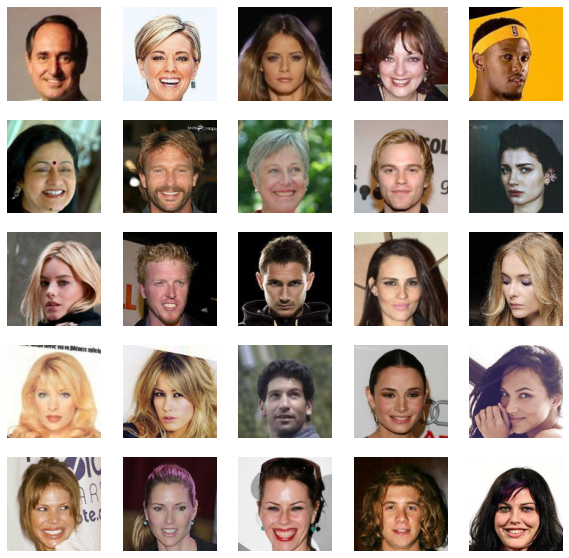

In [3]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [4]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

LATENT_DIM = 32
CHANNELS = 3

Using TensorFlow backend.
/home/alumno2/anaconda3/envs/gan1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alumno2/anaconda3/envs/gan1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alumno2/anaconda3/envs/gan1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alumno2/anaconda3

In [5]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator



generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

In [6]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/home/alumno2/anaconda3/envs/gan1/lib/python3.6/site-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50/5000: d_loss: 0.8038,  a_loss: 0.9298.  (66.9 sec)
100/5000: d_loss: 0.7212,  a_loss: 0.9936.  (67.1 sec)
150/5000: d_loss: 0.5971,  a_loss: 0.6960.  (67.3 sec)
200/5000: d_loss: 0.5184,  a_loss: 1.0581.  (67.2 sec)
250/5000: d_loss: 0.2644,  a_loss: 1.5738.  (67.1 sec)
300/5000: d_loss: 0.7729,  a_loss: 2.1220.  (66.9 sec)
350/5000: d_loss: 0.7671,  a_loss: 1.5670.  (67.0 sec)
400/5000: d_loss: 0.6167,  a_loss: 1.4828.  (66.7 sec)
450/5000: d_loss: 0.7586,  a_loss: 0.5342.  (67.1 sec)
500/5000: d_loss: 0.7001,  a_loss: 0.7061.  (66.9 sec)
550/5000: d_loss: 0.7563,  a_loss: 1.7401.  (67.2 sec)
600/5000: d_loss: 0.9405,  a_loss: 1.0198.  (66.9 sec)
650/5000: d_loss: 0.8566,  a_loss: 0.9053.  (67.0 sec)
700/5000: d_loss: 0.7221,  a_loss: 1.8776.  (67.0 sec)
750/5000: d_loss: 0.5997,  a_loss: 0.9166.  (66.8 sec)
800/5000: d_loss: 0.7715,  a_loss: 0.7923.  (67.2 sec)
850/5000: d_loss: 0.6898,  a_loss: 0.6879.  (67.0 sec)
900/5000: d_loss: 0.7070,  a_loss: 0.8050.  (66.8 sec)
950/5000: d

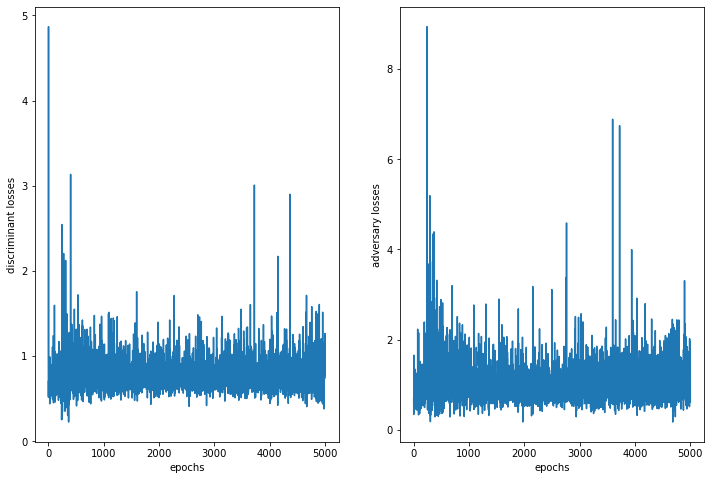

ValueError: Could not find a format to read the specified file in single-image mode

In [7]:
import os
import time
iters = NUMERO_ITERACIONES 
batch_size = BATCH



RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0

for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % NUMERO_ITERACIONES_A_GUARDAR == (NUMERO_ITERACIONES_A_GUARDAR - 1):
        gan.save_weights('/home/alumno2/Desktop/weights/gan.h5')  

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]

        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('/home/alumno2/Desktop/gif/visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)
